In [4]:
# Importing the modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
plt.rcParams.update({'font.serif':'Arial', 'font.size': 15.0, 
                     'xtick.labelsize': 15, 'ytick.labelsize': 15,
                    'legend.fontsize':15,
                    'figure.dpi': 80.0, 'figure.figsize': [9, 5]})

In [6]:
def read_data(filename, sort_by):
    with open(filename, "r") as file:   # jid=253256
        lines = file.readlines()
        header = lines[8].split()[2:]
        timestep = int(lines[1].split()[0])
        natom = int(lines[3].split()[0])
        dump_top = lines[0:8]
#         print('Header\n', header)
        total_lines = len(lines)
        print('Total lines:', total_lines)

        # Reading the data:
        data = np.array([list(map(float, line.strip().split())) for line in lines[dump_offset:]])
        
        # Sorting the data according to position:
        sorted_index = np.argsort(data[:, sort_by])
        data = data[sorted_index]
    return dump_top, natom, header, data


In [7]:
# Reading the fingerprint data:
fingerprint = pd.read_csv('fingerprint.dat', header = None, delimiter='\t')
CNrescale = 10                             # Value used to rescale coordination number
# Dataformat:
# Rows: Q1-Q12 and CN-Co, Si, O
fingerprint.iloc[12:] /= CNrescale
total_col = fingerprint.shape[1]

#Reading the dumpfile:
Temp = 2500
file_loc = './Mayada_growth_800K/Annealing/'
MD_str=f'{file_loc}/dump_aveSOP_{Temp}K.lmc'

dump_offset = 9

dump_top, natom, header, data = read_data(MD_str, 0)   # Data sorted by atom type

data[:, -4:] = data[:, -4:]/CNrescale        # Rescaling the coordination number 

Total lines: 16935


In [8]:
# Calculating the L1 norm:
new_data = []

for i in np.arange(natom):
#     print(data[i, 1] == 1)
    if data[i, 1] == 1:  # Co ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(0, total_col, 3)])   # 0 = Co of chiral
    if data[i, 1] == 2:  # Si ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(1, total_col, 3)])   # 1 = Si of chiral
    if data[i, 1] == 3:  # O ref 
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(2, total_col, 3)])   # 2 = O of chiral
    if data[i, 1] == 4:  # Si ref
        new_data.append([np.sum(np.abs(data[i, 7:]-fingerprint[2:][j])) for j in np.arange(1, total_col, 3)])   # 1 = Si of chiral

In [9]:
# Converting to pandas dataframe:
title1 = ['v_normCoSi', 'v_normACoSi', 'v_normCo2Si', 'v_normCoSi2', 'v_Co', 'v_Si', 'v_SiO2']
new_data = pd.DataFrame(new_data, columns = title1)

# Now combine with position
title2 = ['ITEM: ATOMS id', 'type', 'x', 'y', 'z']
pos_data = pd.DataFrame(data[:, 0:5], columns = title2)

df_combined_data = pd.concat([pos_data, new_data], axis=1)
df_combined = np.array(df_combined_data)

In [10]:
# Write the datafile:
new_dump = f'{file_loc}/dump_norm_{Temp}.lmp'

with open(new_dump, "w") as output_file:
    
# Writing the structural details, natoms, box size
    for i in dump_top:
        output_file.write(i)
    
#     output_file.write('\n')
    combined_list = title2 + title1

    for i in range(len(combined_list)):
        output_file.write(combined_list[i] + '\t')
    
    output_file.write('\n')
    
    for item in df_combined:
        output_file.write(str(int(item[0]))+ '\t' + '\t'.join(str(elem) for elem in item[1:]) + '\n')

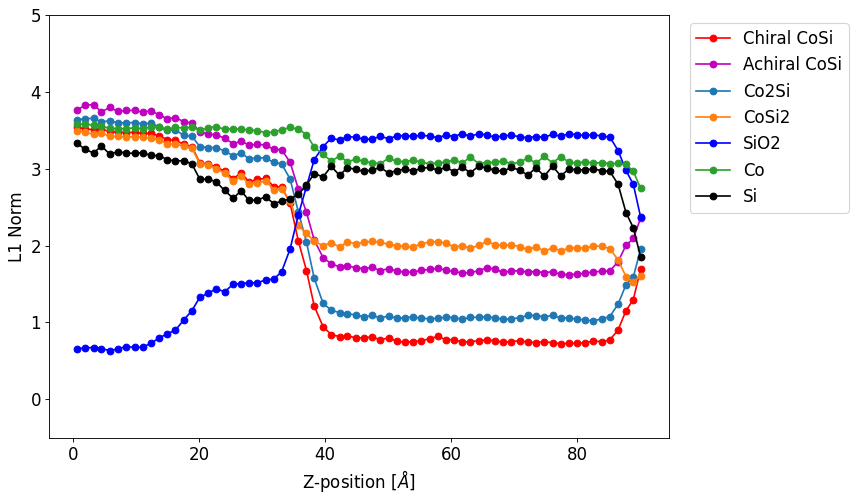

In [11]:
# reading the processed dump:
sorted_df = df_combined_data.sort_values(by=['z'])
min_val = sorted_df['z'].min()            # min z-value
max_val = sorted_df['z'].max()            # max z-value
sorted_df['z']= sorted_df['z']- min_val   # Rescaling the z-position

# print(sorted_df)

diff = 1.3
zlength = sorted_df['z'].max() + 1        # Z-axis box length

ranges = [(i*diff, (i+1)*diff) for i in range(int(np.round(zlength/diff)))]

# print(ranges)
# Calculate averages:
averages = {}

for start, end in ranges:
    group_df = sorted_df[sorted_df['z'].between(start, end)]
#     print(group_df)
    averages[(start, end)] = group_df.mean(numeric_only=True)
    
df_averages = pd.DataFrame(averages).T

# Plotting the data:
fig = plt.figure(figsize=(10,7))
plt.plot(df_averages['z'], df_averages['v_normCoSi'], 'or-', label='Chiral CoSi')
plt.plot(df_averages['z'], df_averages['v_normACoSi'], 'om-', label='Achiral CoSi')
plt.plot(df_averages['z'], df_averages['v_normCo2Si'], 'o-', label='Co2Si')
plt.plot(df_averages['z'], df_averages['v_normCoSi2'], 'o-', label='CoSi2')
plt.plot(df_averages['z'], df_averages['v_SiO2'], 'ob-', label='SiO2')
plt.plot(df_averages['z'], df_averages['v_Co'], 'o-', label='Co')
plt.plot(df_averages['z'], df_averages['v_Si'], 'ok-', label='Si')
plt.ylim(-0.5, 5)
# plt.xlim(-5, 69)
# plt.xlim(-0.5, 5)
plt.xlabel('Z-position [$\AA$]')
plt.ylabel('L1 Norm')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
# plt.savefig(f"{file_loc}/L1_norm_averaging_{Temp}.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()

df_averages.to_csv(f"{file_loc}/L1_Norm_data_{Temp}.dat", index=False)

In [9]:
# np.array(df_averages.mean()).reshape(-1)
print(df_averages[25:39].mean())
# print(df_averages[0:20].mean())
# df_averages.mean()

ITEM: ATOMS id    19465.080408
type                  1.812978
x                    25.729700
y                    25.709635
z                    41.594870
v_normCoSi            1.262982
v_normACoSi           2.082014
v_normCo2Si           1.574818
v_normCoSi2           2.146288
v_Co                  3.237473
v_Si                  2.880579
v_SiO2                3.026389
dtype: float64


In [10]:
df_averages[25:39]

,,ITEM: ATOMS id,type,x,y,z,v_normCoSi,v_normACoSi,v_normCo2Si,v_normCoSi2,v_Co,v_Si,v_SiO2
32.5,33.8,13904.520362,2.592760,25.882439,25.704433,33.099780,2.762273,3.247493,3.062515,2.731844,3.507757,2.577822,1.661386
33.8,35.1,14990.869767,2.506977,25.166724,25.042061,34.442053,2.551308,3.084406,2.866955,2.583326,3.536809,2.607203,1.956780
35.1,36.4,16952.186441,2.182203,26.672063,25.729221,35.736086,2.063368,2.740658,2.442279,2.264966,3.513986,2.665802,2.396675
36.4,37.7,18272.225806,1.990783,25.276604,26.248118,37.036402,1.675761,2.433511,2.044721,2.159684,3.444925,2.786780,2.768745
37.7,39.0,20186.582375,1.731801,26.021928,26.255129,38.272924,1.212581,2.069886,1.573678,2.056442,3.279823,2.937653,3.119328
39.0,40.3,20360.003636,1.683636,25.437487,26.691757,39.666641,0.945096,1.844518,1.250637,1.999773,3.187680,2.892870,3.286148
40.3,41.6,21053.839552,1.529851,25.895373,24.867281,40.977425,0.842368,1.761621,1.157941,2.037961,3.099611,3.031441,3.398940
41.6,42.9,21188.549020,1.643137,26.281137,25.525059,42.286402,0.815650,1.724409,1.128715,1.980818,3.165310,2.912248,3.371349
42.9,44.2,21139.225191,1.568702,25.412732,26.315960,43.528599,0.824263,1.736759,1.112766,2.049237,3.090932,3.015269,3.418928
44.2,45.5,20872.070896,1.608209,25.169551,24.514643,44.850940,0.802010,1.711923,1.098994,2.024634,3.122553,2.990246,3.408761
